In [63]:
from itertools import combinations
from collections import defaultdict, namedtuple
from math import isclose

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.patches import Polygon

rng = np.random.default_rng(seed=1)

grid_count = 8
grid_bounds = [-5, 5]
grid_bounds[1] += 1
#cos_list = [np.cos(x * np.pi / grid_count) for x in np.arange(grid_count)]
#sin_list = [np.sin(x * np.pi / grid_count) for x in np.arange(grid_count)]
cos_list = [np.cos(x * 2 * np.pi / grid_count) for x in np.arange(grid_count)]
sin_list = [np.sin(x * 2 * np.pi / grid_count) for x in np.arange(grid_count)]

offsets = rng.uniform(size=grid_count)
offsets = offsets / np.sum(offsets)
offsets = np.repeat(1/grid_count, grid_count)
offsets = np.repeat(.25, grid_count)
# offsets = np.empty((grid_count,),float)
# offsets[::2] = (1/grid_count)
# offsets[1::2] = -(1/grid_count)
#offsets = np.repeat(0, grid_count)
#offsets = np.repeat(1/grid_count, grid_count)

class Line:
    # a*x + b*y = c
    def __init__(self, a, b, o, k, grid):
        self.a = a
        self.b = b
        self.c = o + k
        self.offset = o
        self.k = k
        self.grid = grid

        self.first_angle = np.arctan2(-a, b)
        if self.first_angle < 0:
            self.second_angle = self.first_angle + np.pi
        else:
            self.second_angle = self.first_angle - np.pi

        # crossing counter clockwise, first angle is k + 1, second is k
        # because of how np.arctan2 works?
        angle = namedtuple('angle', ['value', 'k', 'grid'])

        self.angles = [angle(self.first_angle, self.k + 1, grid), 
                       angle(self.second_angle, self.k, grid)]

        # Find closes point to the origin
        self.origin_x = (self.a * self.c) / (self.a**2 + self.b**2)
        self.origin_y = (self.b * self.c) / (self.a**2 + self.b**2)

        self.perpendicular_angle = np.arctan2(b, a)

        # Keep this stuff in here for testing, but add parameter to exclude it later
        self.p1 = [np.cos(self.perpendicular_angle) * .25 + self.origin_x,
              np.sin(self.perpendicular_angle) * .25 + self.origin_y ]
        self.p2 = [np.cos(self.perpendicular_angle) * -.25 + self.origin_x,
              np.sin(self.perpendicular_angle) * -.25 + self.origin_y ]

        self.K = [self.determine_K(self.p1), self.determine_K(self.p2)]

    def __str__(self):
        return f'a={self.a}, b={self.b}, offset={self.offset}, k={self.k}, grid={self.grid}'

    def determine_K(self, p):
        return np.ceil(self.a * p[0] + self.b * p[1] - self.offset)

    # Build function to get lines that hit boundaries
    # Maybe use build intersection function and use a line for each boundary!!!???
    def determine_intersection(self, other_line):

        denom = (self.a * other_line.b) - (other_line.a * self.b)
        if isclose(denom, 0, rel_tol=1e-5, abs_tol=1e-05):
            # Determine if it's the same line
            if isclose(other_line.a, 0, rel_tol=1e-5, abs_tol=1e-05):
                if not isclose(self.a, 0, rel_tol=1e-5, abs_tol=1e-05):
                    # Different lines
                    return None
                a_proportion = 0
            else:
                a_proportion = self.a / other_line.a
            
            if isclose(other_line.b, 0, rel_tol=1e-5, abs_tol=1e-05):
                if not isclose(self.b, 0, rel_tol=1e-5, abs_tol=1e-05):
                    # Different lines
                    return None
                b_proportion = 0
            else:
                b_proportion = self.b / other_line.b

            if a_proportion and b_proportion:
                if not isclose(a_proportion, b_proportion):
                    return None

            if isclose(other_line.c, 0, rel_tol=1e-5, abs_tol=1e-05):
                if not isclose(self.c, 0, rel_tol=1e-5, abs_tol=1e-05):
                    # Different lines
                    return None
                c_proportion = 0
            else:
                c_proportion = self.c / other_line.c

            if a_proportion and c_proportion:
                if not isclose(a_proportion, c_proportion):
                    return None
            
            if b_proportion and c_proportion:
                if not isclose(b_proportion, c_proportion):
                    return None

            raise OverlappingLines(self, other_line)
        else:
            x = (other_line.b * self.c) - (self.b * other_line.c)
            x = x / denom

            y = (self.a * other_line.c) - (other_line.a * self.c)
            y = y / denom

            return (x, y)
        
class OverlappingLines(Exception):
    def __init__(self, line_1, line_2, msg="These two lines are the same line."):
        self.line_1 = line_1
        self.line_2 = line_2
        self.msg = msg
        super().__init__(self.msg)

    def __str__(self):
        return f'{self.msg}\n\t{self.line_1}\n\t{self.line_2}'
                
grids = []
for i, (s, c, o) in enumerate(zip(sin_list, cos_list, offsets)):
    for k in np.arange(*grid_bounds):
        grids.append(Line(c, s, o, k, i))

boundary = [Line(0, 1, 4, 1, 0), Line(0, 1, -4, -1, 0), Line(1, 0, 4, 1, 0), Line(1, 0, -4, -1, 0)]

draw_lines = []

for l in grids:
    points = []
    for b in boundary:
        try:
            intersection = l.determine_intersection(b)
            if intersection:
                points.append(intersection)
        except OverlappingLines as e: 
            continue
    draw_lines.append(points)

colors = ["blue", "green", "yellow", "orange", "red"]
colors = np.repeat(colors, len(draw_lines) / 5)

intersections = defaultdict(set)
for pair in combinations(grids, 2):
    l1 = pair[0]
    l2 = pair[1]
    
    if l1.grid == l2.grid:
        continue

    try:
        intersection = l1.determine_intersection(l2)
        intersections[intersection].update([l1, l2])
    except OverlappingLines as e: 
        print(e)

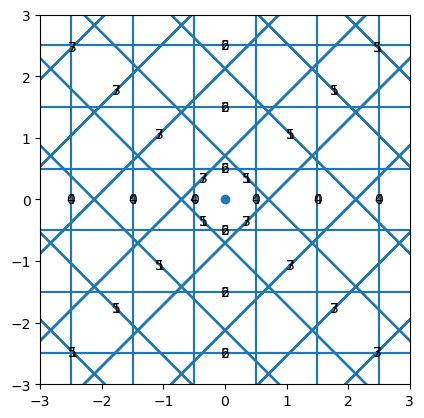

In [62]:
graph_bounds = 4

boundary = [Line(0, 1, graph_bounds, 1, 0), 
            Line(0, 1, -graph_bounds, 1, 0), 
            Line(1, 0, graph_bounds, 1, 0), 
            Line(1, 0, -graph_bounds, 1, 0)]

graph_bounds -= 1

draw_lines = []

for l in grids:
    points = []
    for b in boundary:
        try:
            intersection = l.determine_intersection(b)
            if intersection:
                points.append(intersection)
        except OverlappingLines as e: 
            print(e)
    if points:
        draw_lines.append(points)

fig, ax = plt.subplots()
ax.add_collection(LineCollection(draw_lines))

for i, l in enumerate(grids):
    if (-graph_bounds < l.origin_x and
        l.origin_x < graph_bounds and
        -graph_bounds < l.origin_y and
        l.origin_y < graph_bounds):
        ax.text(x=l.origin_x, y=l.origin_y, s=l.grid,
                horizontalalignment='center',
                verticalalignment='center')

ax.scatter(x=0, y=0)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_aspect('equal')
plt.show()

# add colors, figure out oklab


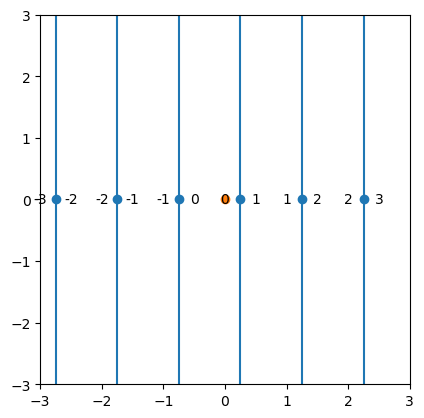

In [3]:
one_grid = [l for l in grids if l.grid == 0]

graph_bounds = 4

boundary = [Line(0, 1, graph_bounds, 1, 0), 
            Line(0, 1, -graph_bounds, 1, 0), 
            Line(1, 0, graph_bounds, 1, 0), 
            Line(1, 0, -graph_bounds, 1, 0)]

graph_bounds -= 1

draw_lines = []

for l in one_grid:
    points = []
    for b in boundary:
        try:
            intersection = l.determine_intersection(b)
            points.append(intersection)
        except NoIntersection as e: 
            continue
    if points:
        draw_lines.append(points)

closest_points = [[l.origin_x, l.origin_y] for l in one_grid]

k_points = [l.p1 for l in one_grid]
k_points.extend([l.p2 for l in one_grid])

fig, ax = plt.subplots()
ax.add_collection(LineCollection(draw_lines))
ax.scatter(*zip(*closest_points))

for i, l in enumerate(one_grid):
    if (-graph_bounds < l.origin_x and
        l.origin_x < graph_bounds and
        -graph_bounds < l.origin_y and
        l.origin_y < graph_bounds):
        ax.text(x=l.p1[0], y=l.p1[1], s=l.angles[0][1],
                horizontalalignment='center',
                verticalalignment='center')
        ax.text(x=l.p2[0], y=l.p2[1], s=l.angles[1][1],
                horizontalalignment='center',
                verticalalignment='center')

ax.scatter(x=0, y=0)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_aspect('equal')
plt.show()


In [4]:
# ok, we're at a point and we have the lines that intersect. 
# We can find K for all the other lines at that point.
# We can find K for both sides of the lines by using the perpendicular line arctan2(b, a)
# We can put the lines in order by using the angles


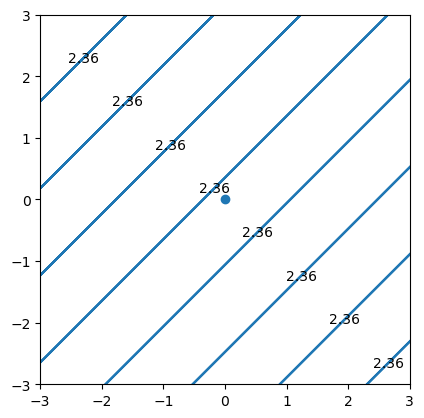

[angle(value=0.7853981633974483, k=-4, grid=3), angle(value=-2.356194490192345, k=-5, grid=3)]


In [5]:
one_grid = [l for l in grids if l.grid == 3]

boundary = [Line(0, 1, 4, 1, 0), Line(0, 1, -4, -1, 0), Line(1, 0, 4, 1, 0), Line(1, 0, -4, -1, 0)]
#boundary = [Line(0, 1, 5, 0), Line(0, 1, -5, 0), Line(1, 0, 5, 0), Line(1, 0, -5, 0)]

draw_lines = []

for l in one_grid:
    points = []
    for b in boundary:
        try:
            intersection = l.determine_intersection(b)
            points.append(intersection)
        except NoIntersection as e: 
            continue
    draw_lines.append(points)

closest_points = [[l.origin_x, l.origin_y] for l in one_grid]

k_points = [l.p1 for l in one_grid]
k_points.extend([l.p2 for l in one_grid])

fig, ax = plt.subplots()
ax.add_collection(LineCollection(draw_lines))

for i, l in enumerate(one_grid):
    if (-graph_bounds < l.origin_x and
        l.origin_x < graph_bounds and
        -graph_bounds < l.origin_y and
        l.origin_y < graph_bounds):
        ax.text(x=l.origin_x, y=l.origin_y, s=round(l.perpendicular_angle, 2),
                horizontalalignment='center',
                verticalalignment='center')

ax.scatter(x=0, y=0)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_aspect('equal')
plt.show()

print(one_grid[0].angles)

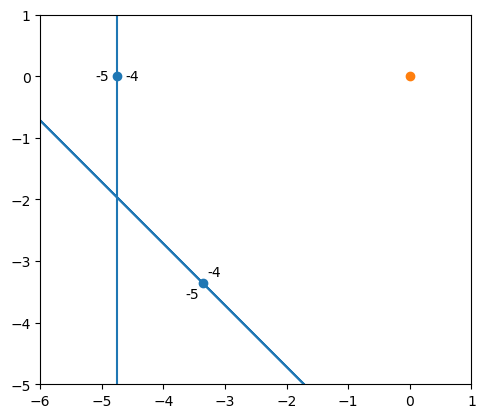

In [6]:
intersection_points, intersection_lines = list(intersections.items())[0]

lower_x = 0
upper_x = 0
lower_y = 0
upper_y = 0

for l in intersection_lines:
    if l.p1[0] < lower_x:
        lower_x = l.p1[0]
    if l.p1[0] > upper_x:
        upper_x = l.p1[0]
    if l.p2[0] < lower_x:
        lower_x = l.p2[0]
    if l.p2[0] > upper_x:
        upper_x = l.p2[0]
    if l.p1[1] < lower_y:
        lower_y = l.p1[1]
    if l.p1[1] > upper_y:
        upper_y = l.p1[1]
    if l.p2[1] < lower_y:
        lower_y = l.p2[1]
    if l.p2[1] > upper_y:
        upper_y = l.p2[1]

lower_x = round(lower_x) - 1
upper_x = round(upper_x) + 1
lower_y = round(lower_y) - 1
upper_y = round(upper_y) + 1

boundary = [Line(0, 1, upper_y, 1, 0), Line(0, 1, lower_y, -1, 0), 
            Line(1, 0, upper_x, 1, 0), Line(1, 0, lower_x, -1, 0)]

draw_lines = []

for l in intersection_lines:
    points = []
    for b in boundary:
        try:
            intersection = l.determine_intersection(b)
            points.append(intersection)
        except NoIntersection as e: 
            continue
    draw_lines.append(points)

closest_points = [[l.origin_x, l.origin_y] for l in intersection_lines]

k_points = [l.p1 for l in intersection_lines]
k_points.extend([l.p2 for l in intersection_lines])

fig, ax = plt.subplots()
ax.add_collection(LineCollection(draw_lines))
ax.scatter(*zip(*closest_points))

for i, l in enumerate(intersection_lines):
    ax.text(x=l.p1[0], y=l.p1[1], s=l.angles[0][1],
            horizontalalignment='center',
            verticalalignment='center')
    ax.text(x=l.p2[0], y=l.p2[1], s=l.angles[1][1],
            horizontalalignment='center',
            verticalalignment='center')

ax.scatter(x=0, y=0)
ax.set_xlim(lower_x, upper_x)
ax.set_ylim(lower_y, upper_y)
ax.set_aspect('equal')
plt.show()

In [64]:
intersection_points, intersection_lines = list(intersections.items())[0]

# Maybe, get all the angles in order
angles = list(intersection_lines)[0].angles.copy()
angles.extend(list(intersection_lines)[1].angles.copy())
angles.sort()
angles
# now determine which K goes on what side, (use offset for this?) maybe need to compute it, determine K by moving back 90 degrees
# no, assign an appropriate K for each angle by moving counter-wise, pick K that is on the next side, probably need to work with quadrants
# yeah, if angle1 is positive, then angle2 hits first, if angle1 is negative, then angle1 hit first
# maybe??? if angle2 hits first, then k, else k+1

# #start with right above (or below) the first one, (maybe need to get to second+ line to get all the K's) then continue looping through
def determine_K(c, x, s, y, o):
    return np.ceil(c * x + s * y - o)

ks = [determine_K(c, intersection_points[0], s, intersection_points[1], o) for c, s, o in zip(cos_list, sin_list, offsets)]

# Now spin around to ensure the ks are correct on the lines that intersect
for angle in angles:
    ks[angle.grid] = angle.k

points = []
for angle in angles:
    ks[angle.grid] = angle.k
    point = np.array([0, 0], dtype=float)
    for k, c, s in zip(ks, cos_list, sin_list):
        point += k * np.array([c, s])
    points.append(point)

points


[array([-18.89949494,  -8.24264069]),
 array([-18.19238816,  -7.53553391]),
 array([-19.19238816,  -7.53553391]),
 array([-19.89949494,  -8.24264069])]

In [65]:
class Tile:
    def __init__(self, points):
        self.points = points
        self.tile_group = 0

        # Don't need to compare distances between angles, always 1 by construction
        self.angles = []
        for i, point in enumerate(self.points):
            previous_point = self.points[(i - 1) % len(self.points)]
            next_point = self.points[(i + 1) % len(self.points)]

            in_vector = point - previous_point
            out_vector = next_point - point
            angle = np.arctan2(in_vector[0]*out_vector[1]-in_vector[1]*out_vector[0],
                            in_vector[0]*out_vector[0]+in_vector[1]*out_vector[1])

            self.angles.append(angle)

    def compare_angles(self, other_polygon):
        if len(self.angles) != len(other_polygon.angles):
            return False

        start = 0
        matched = False
        while start < len(self.angles) and not matched:
            for i in range(len(self.angles)):
                place = (i + start) % len(self.angles)
                if not isclose(self.angles[place], other_polygon.angles[i]):
                    break
            if i == len(self.angles)-1:
                matched = True
            start += 1
        
        return matched

In [66]:
base_tiles = []
tiles = []

for intersection_points, intersection_lines in intersections.items():

    # Maybe, get all the angles in order
    angles = list(intersection_lines)[0].angles.copy()
    angles.extend(list(intersection_lines)[1].angles.copy())
    angles.sort()
    angles
    # now determine which K goes on what side, (use offset for this?) maybe need to compute it, determine K by moving back 90 degrees
    # no, assign an appropriate K for each angle by moving counter-wise, pick K that is on the next side, probably need to work with quadrants
    # yeah, if angle1 is positive, then angle2 hits first, if angle1 is negative, then angle1 hit first
    # maybe??? if angle2 hits first, then k, else k+1

    # #start with right above (or below) the first one, (maybe need to get to second+ line to get all the K's) then continue looping through
    def determine_K(c, x, s, y, o):
        return np.ceil(c * x + s * y - o)

    ks = [determine_K(c, intersection_points[0], s, intersection_points[1], o) for c, s, o in zip(cos_list, sin_list, offsets)]

    # Now spin around to ensure the ks are correct on the lines that intersect
    for angle in angles:
        ks[angle.grid] = angle.k

    points = []
    for angle in angles:
        ks[angle.grid] = angle.k
        point = np.array([0, 0], dtype=float)
        for k, c, s in zip(ks, cos_list, sin_list):
            point += k * np.array([c, s])
        points.append(point)

    t = Tile(points)

    bt_match = False
    for bt in base_tiles:
        if bt.compare_angles(t):
            t.tile_group = bt.tile_group
            bt_match = True
            break

    if not bt_match:
        t.tile_group = len(base_tiles)
        base_tiles.append(t)

    tiles.append(t)

TypeError: 'NoneType' object is not subscriptable

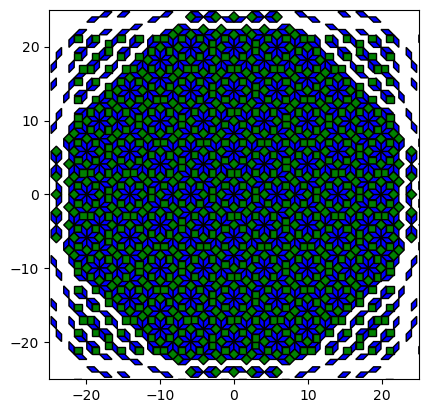

In [20]:
colors = ["blue", "green", "yellow", "orange", "red"]

fig,ax = plt.subplots()

for t in tiles:
    p = Polygon(t.points, facecolor = colors[t.tile_group], edgecolor="k")
    ax.add_patch(p)
    
ax.set_xlim([-25,25])
ax.set_ylim([-25,25])
ax.set_aspect('equal')
plt.show()

In [11]:
# still need to figure out why 8, .5 doesn't work. Need to fail out when lines overlap, and skip when just parallel

In [12]:
# Figure out how to limit so it fills up the space?
# Start in the middle and expand out until hitting an edge?
# subtract out the overall mean, built a graph that has each boundary increase by 1 (as a square), stop when hitting white, save largest

NameError: name 'polygons' is not defined

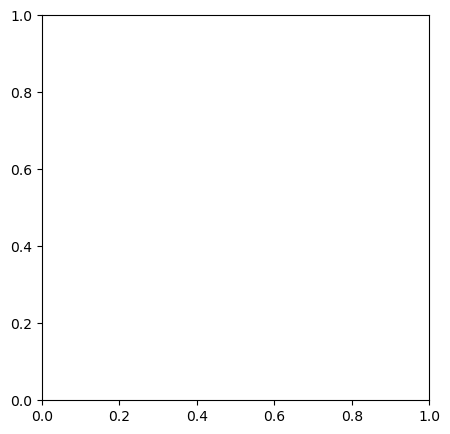

In [13]:
plot_bounds = 1
fig, ax = plt.subplots(figsize=(5, 5))

for polygon in polygons:
    p = Polygon(polygon, facecolor = 'green', edgecolor="k")
    ax.add_patch(p)
    
ax.set_xlim([-10,10])
ax.set_ylim([-10,10])
ax.set_aspect('equal')

plt.axis([-1, 1, -1, 1])
plt.axis('off')
plt.tight_layout(pad=0)

plt.savefig("test.png", dpi=150)

In [14]:
from PIL import *
im = Image.open("test.png")


NameError: name 'polygons' is not defined

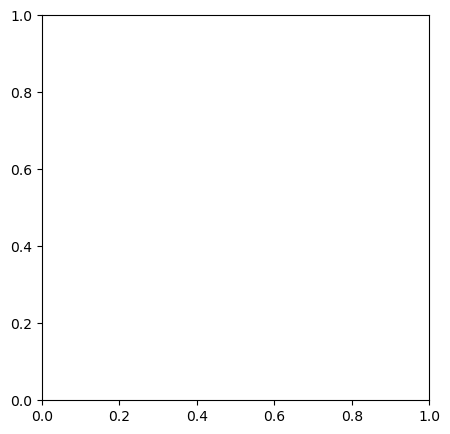

In [15]:
plot_bounds = 0
no_white = True

while no_white:
    plot_bounds += 1
    fig, ax = plt.subplots(figsize=(5, 5))

    for polygon in polygons:
        p = Polygon(polygon, facecolor = 'green', edgecolor="k")
        ax.add_patch(p)
        
    ax.set_aspect('equal')
    plt.axis([-plot_bounds, plot_bounds, -plot_bounds, plot_bounds])
    plt.axis('off')
    plt.tight_layout(pad=0)

    plt.savefig("test.png", dpi=150)
    plt.close()

    im = Image.open("test.png")

    for pixel in im.getdata():
        if pixel == (255, 255, 255, 255):
            no_white = False

    print(plot_bounds)

plot_bounds -= 1
fig, ax = plt.subplots(figsize=(5, 5))

for polygon in polygons:
    p = Polygon(polygon, facecolor = 'green', edgecolor="k")
    ax.add_patch(p)
    
ax.set_aspect('equal')
plt.axis([-plot_bounds, plot_bounds, -plot_bounds, plot_bounds])
plt.axis('off')
plt.tight_layout(pad=0)

plt.savefig("test.png", dpi=150)
plt.close()

In [16]:
# Maybe jump up by 5s then drop by ones until it works?
# Get min max, then bisect
tiles[0].points[0][0]

-18.899494936611667

In [50]:
boundary_max = abs(tiles[0].points[0][0])
# x_total = 0
# y_total = 0

for t in tiles:
    for p in t.points:
        # x_total += p[0]
        # y_total += p[1]

        if abs(p[0]) > boundary_max:
            boundary_max = abs(p[0])
        if abs(p[1]) > boundary_max:
            boundary_max = abs(p[1])

# print(x_max, y_max, x_total / len(tiles), y_total / len(tiles))
print(np.ceil(boundary_max))


51.0


In [52]:
colors = ["blue", "green", "yellow", "orange", "red"]

current_boundry = boundary_max
boundary_min = 1
no_white = True

step = 0

while (boundary_max - boundary_min) > 1:
    fig, ax = plt.subplots(figsize=(5, 5))

    for t in tiles:
        p = Polygon(t.points, facecolor = colors[t.tile_group], edgecolor="k")
        ax.add_patch(p)
        
    ax.set_aspect('equal')
    plt.axis([-current_boundry, current_boundry, -current_boundry, current_boundry])
    plt.axis('off')
    plt.tight_layout(pad=0)

    graph_file = "graph.png"
    # graph_file = f"test_{step}.png"
    plt.savefig(graph_file, dpi=150)
    plt.close()

    im = Image.open(graph_file)

    no_white = True
    for pixel in im.getdata():
        if pixel == (255, 255, 255, 255):
            no_white = False
            break
    
    if no_white:
        current_boundry, boundary_min = (current_boundry + boundary_max) / 2, current_boundry
    else:
        current_boundry, boundary_max = (current_boundry + boundary_min) / 2, current_boundry

    boundary_min = round(boundary_min)
    current_boundry = round(current_boundry)
    boundary_max = round(boundary_max)



In [46]:
im = Image.open(f"test_3.png")

for pixel in im.getdata():
    if pixel == (255, 255, 255, 255):
        print(f'here {step}')
        no_white = False
        break

In [ ]:
# still need to figure out why 8, .5 doesn't work. Need to fail out when lines overlap, and skip when just parallel
# need to check when they overlap, just skip when parallel
# overlap has same proportion between a, b, and c